In [1]:
# =========================================================
# Enhanced HMM with Regression + Large Simulation + Tuning
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# ----------------------------
# States
# ----------------------------
states = ["learning", "practicing", "mastered"]
n_states = 3

# ----------------------------
# Initial distribution
# ----------------------------
pi = np.array([0.2, 0.6, 0.2])

# ----------------------------
# Transition matrix WITH regression
# ----------------------------
A = np.array([
    [0.70, 0.28, 0.02],  # learning
    [0.05, 0.85, 0.10],  # practicing
    [0.00, 0.08, 0.92]   # mastered (can regress slightly)
])

# ----------------------------
# Base mastery levels
# ----------------------------
base_mastery = {
    "learning": 0.35,
    "practicing": 0.55,
    "mastered": 0.90
}

difficulty_multiplier = {
    "easy": 1.0,
    "moderate": 0.9,
    "hard": 0.75
}

# ----------------------------
# Belief update
# ----------------------------
def update_belief(belief, observation, difficulty, slip, guess, persistence):
    new_belief = np.zeros_like(belief)
    
    for i, state in enumerate(states):
        mastery = base_mastery[state]
        
        # Persistence modifies slip (more persistent → less slip)
        adj_slip = slip * (1 - 0.5 * persistence)
        
        p_correct = mastery * (1 - adj_slip) + (1 - mastery) * guess
        p_correct *= difficulty_multiplier[difficulty]
        
        emission = p_correct if observation == 1 else (1 - p_correct)
        transition_sum = np.sum(belief * A[:, i])
        new_belief[i] = emission * transition_sum
    
    new_belief /= np.sum(new_belief)
    return new_belief



In [3]:
# =========================================================
# Simulate 1000 students
# =========================================================

n_students = 1000
n_steps = 25

pred_probs = []
true_outcomes = []

for _ in range(n_students):
    
    belief = pi.copy()
    
    slip = np.random.uniform(0.05, 0.12)
    guess = np.random.uniform(0.10, 0.20)
    persistence = np.random.uniform(0.3, 0.9)
    
    for _ in range(n_steps):
        
        difficulty = np.random.choice(["easy", "moderate", "hard"])
        
        # Predict probability of correctness
        mastery_probs = np.array([base_mastery[s] for s in states])
        p_correct_pred = np.sum(belief * mastery_probs)
        
        outcome = np.random.binomial(1, p_correct_pred)
        
        pred_probs.append(p_correct_pred)
        true_outcomes.append(outcome)
        
        belief = update_belief(belief, outcome, difficulty, slip, guess, persistence)

pred_probs = np.array(pred_probs)
true_outcomes = np.array(true_outcomes)

# Calibration metric (Brier score)
brier_score = np.mean((pred_probs - true_outcomes) ** 2)

print("Brier Score:", round(brier_score, 4))


Brier Score: 0.1935


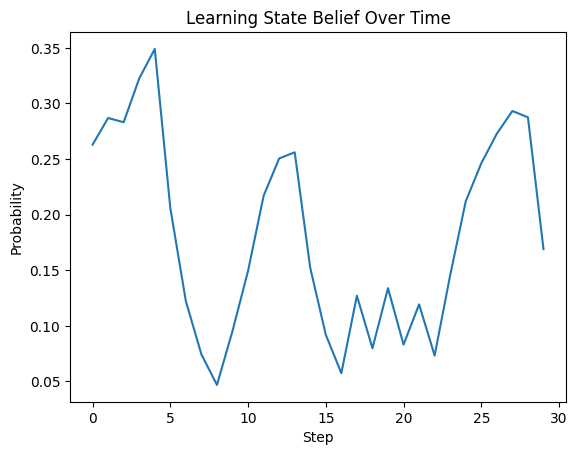

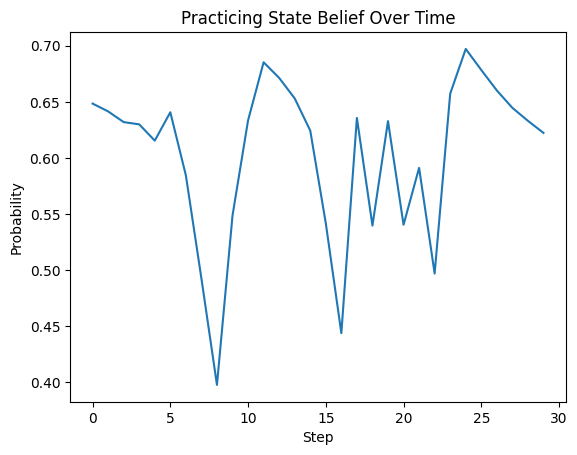

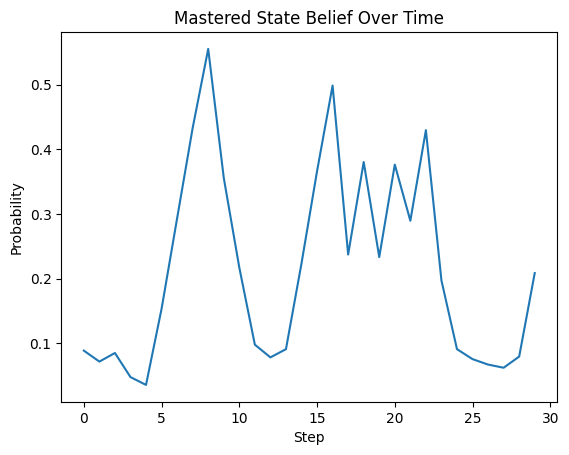

In [5]:
# =========================================================
# Plot Belief Trajectory for One Student
# =========================================================

belief = pi.copy()
trajectory = []

slip = 0.08
guess = 0.15
persistence = 0.7

for _ in range(30):
    difficulty = np.random.choice(["easy", "moderate", "hard"])
    mastery_probs = np.array([base_mastery[s] for s in states])
    p_correct_pred = np.sum(belief * mastery_probs)
    outcome = np.random.binomial(1, p_correct_pred)
    belief = update_belief(belief, outcome, difficulty, slip, guess, persistence)
    trajectory.append(belief.copy())

trajectory = np.array(trajectory)

plt.figure()
plt.plot(trajectory[:,0])
plt.title("Learning State Belief Over Time")
plt.xlabel("Step")
plt.ylabel("Probability")
plt.show()

plt.figure()
plt.plot(trajectory[:,1])
plt.title("Practicing State Belief Over Time")
plt.xlabel("Step")
plt.ylabel("Probability")
plt.show()

plt.figure()
plt.plot(trajectory[:,2])
plt.title("Mastered State Belief Over Time")
plt.xlabel("Step")
plt.ylabel("Probability")
plt.show()


In [7]:
# =========================================================
# Simple Mathematical Transition Tuning
# =========================================================

# Slightly slower mastery progression
A_tuned = np.array([
    [0.75, 0.23, 0.02],
    [0.07, 0.88, 0.05],
    [0.00, 0.10, 0.90]
])

print("Original Transition Matrix:\n", A)
print("\nTuned Transition Matrix:\n", A_tuned)

# =========================================================
# Micro-HMM per Topic (Example for 3 topics)
# =========================================================

topics = ["rotation", "visualization", "pattern"]

micro_hmms = {}

for topic in topics:
    micro_hmms[topic] = {
        "pi": pi.tolist(),
        "A": A_tuned.tolist(),
        "base_mastery": base_mastery
    }

print("\nMicro-HMMs Created for Topics:", topics)

# =========================================================
# Persistence Modifier Demonstration
# =========================================================

low_persistence = 0.2
high_persistence = 0.9

belief_low = pi.copy()
belief_high = pi.copy()

for _ in range(15):
    difficulty = "moderate"
    mastery_probs = np.array([base_mastery[s] for s in states])
    outcome = 1
    
    belief_low = update_belief(belief_low, outcome, difficulty, 0.1, 0.15, low_persistence)
    belief_high = update_belief(belief_high, outcome, difficulty, 0.1, 0.15, high_persistence)

print("\nMastery after 15 correct answers:")
print("Low persistence mastered prob:", round(belief_low[2],3))
print("High persistence mastered prob:", round(belief_high[2],3))


Original Transition Matrix:
 [[0.7  0.28 0.02]
 [0.05 0.85 0.1 ]
 [0.   0.08 0.92]]

Tuned Transition Matrix:
 [[0.75 0.23 0.02]
 [0.07 0.88 0.05]
 [0.   0.1  0.9 ]]

Micro-HMMs Created for Topics: ['rotation', 'visualization', 'pattern']

Mastery after 15 correct answers:
Low persistence mastered prob: 0.859
High persistence mastered prob: 0.86
